In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import math
import numpy as np
from scipy import stats

In [2]:
# HIDDEN

def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

### Error in the regression estimate
Though the average residual is 0, each individual residual is not. Some residuals might be quite far from 0. To get a sense of the amount of error in the regression estimate, we will start with a graphical description of the sense in which the regression line is the "best".

Our example is a dataset that has one point for every chapter of the novel "Little Women." The goal is to estimate the number of characters (that is, letters, punctuation marks, and so on) based on the number of periods. Recall that we attempted to do this in the very first lecture of this course.

In [3]:
little_women = Table.read_table('little_women.csv')
little_women.show(3)

Characters,Periods
21759,189
22148,188
20558,231


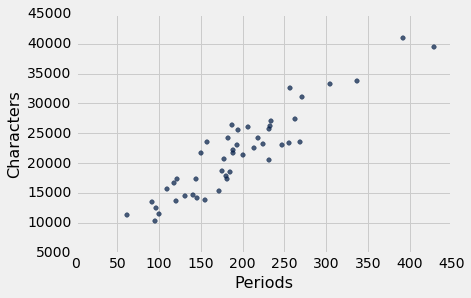

In [4]:
# One point for each chapter
# Horizontal axis: number of periods
# Vertical axis: number of characters (as in a, b, ", ?, etc; not people in the book)

little_women.scatter('Periods', 'Characters')

In [5]:
correlation(little_women, 'Periods', 'Characters')

0.92295768958548163

The scatter plot is remarkably close to linear, and the correlation is more than 0.92.

In [6]:
# HIDDEN

sample = [[131, 14431], [231, 20558], [392, 40935], [157, 23524]]
def lw_errors(slope, intercept):
    little_women.scatter('Periods', 'Characters')
    xlims = np.array([50, 450])
    plt.plot(xlims, slope * xlims + intercept, lw=2)
    for x, y in sample:
        plt.plot([x, x], [y, slope * x + intercept], color='r', lw=2)

The figure below shows the scatter plot and regression line, with four of the errors marked in red.

Slope:     87.0
Intercept: 4745.0


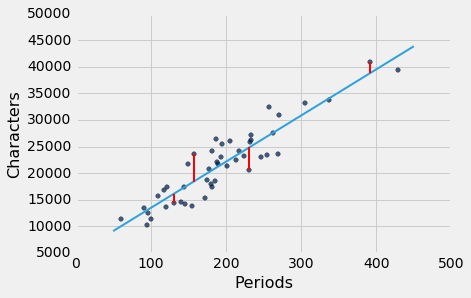

In [7]:
# Residuals: Deviations from the regression line
lw_slope = slope(little_women, 'Periods', 'Characters')
lw_intercept = intercept(little_women, 'Periods', 'Characters')
print('Slope:    ', np.round(lw_slope))
print('Intercept:', np.round(lw_intercept))
lw_errors(lw_slope, lw_intercept)

Had we used a different line to create our estimates, the errors would have been different. The picture below shows how big the errors would be if we were to use a particularly silly line for estimation.

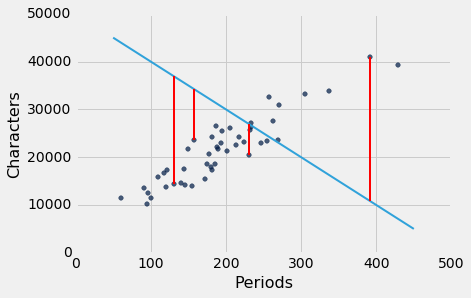

In [8]:
# Errors: Deviations from a different line

lw_errors(-100, 50000)

Below is a line that we have used before without saying that we were using a line to create estimates. It is the horizontal line at the value "average of $y$." Suppose you were asked to estimate $y$ and *were not told the value of $x$*; then you would use the average of $y$ as your estimate, regardless of the chapter. In other words, you would use the flat line below.

Each error that you would make would then be a deviation from average. The rough size of these deviations is the SD of $y$. 

In summary, if we use the flat line at the average of $y$ to make our estimates, the estimates will be off by the SD of $y$.

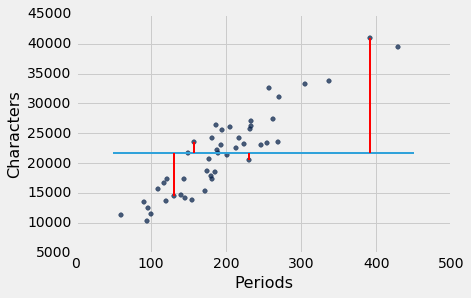

In [9]:
# Errors: Deviations from the flat line at the average of y

characters_average = np.mean(little_women.column('Characters'))
lw_errors(0, characters_average)

### Least Squares

If you use any arbitrary line as your line of estimates, then some of your errors are likely to be positive and others negative. To avoid cancellation when measuring the rough size of the errors, we take the mean of the sqaured errors rather than the mean of the errors themselves. This is exactly analogous to our reason for looking at squared deviations from average, when we were learning how to calculate the SD.

The mean squared error of estimation using a straight line is a measure of roughly how big the squared errors are; taking the square root yields the root mean square error, which is in the same units as $y$.

Here is a remarkable fact of mathematics: the regression line minimizes the mean squared error of estimation (and hence also the root mean squared error) among all straight lines. That is why the regression line is sometimes called the "least squares line."

**Computing the "best" line.**

- To get estimates of $y$ based on $x$, you can use any line you want.
- Every line has a mean squared error of estimation.
- "Better" lines have smaller errors.
- **The regression line is the unique straight line that minimizes the root mean squared error of estimation among all straight lines.**

We can define a function to compute the root mean squared error of any line throught the Little Women scatter diagram.

Root mean squared error: 7019.17593405


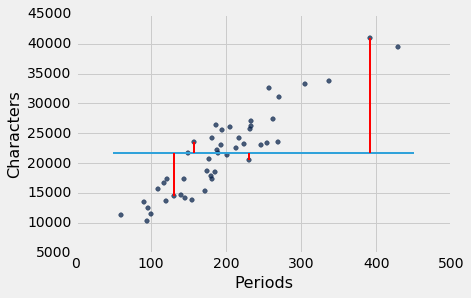

In [10]:
def lw_rmse(slope, intercept):
    lw_errors(slope, intercept)
    x = little_women.column('Periods')
    y = little_women.column('Characters')
    fitted = slope * x + intercept
    rmse = np.average((y - fitted) ** 2) ** 0.5
    print("Root mean squared error:", rmse)

lw_rmse(0, characters_average)

The error of the regression line is indeed much smaller if we choose a slope and intercept near the regression line.

Root mean squared error: 2715.53910638


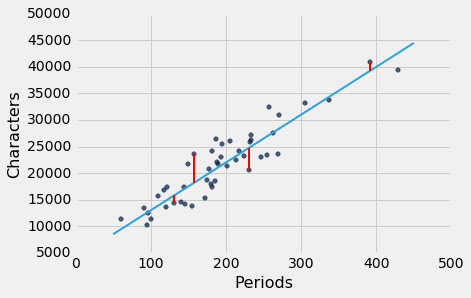

In [11]:
lw_rmse(90, 4000)

But the minimum is achieved using the regression line itself.

Root mean squared error: 2701.69078531


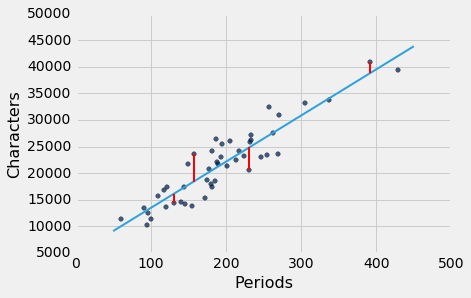

In [12]:
lw_rmse(lw_slope, lw_intercept)

## Numerical Optimization

We can also define `root_mean_squared_error` for an arbitrary data set. We'll use a higher-order function so that we can try many different lines on the same data set, simply by passing in their slope and intercept.

In [13]:
def root_mean_squared_error(table, x, y):
    def for_line(slope, intercept):
        fitted = (slope * table.column(x) + intercept)
        return np.average((table.column(y) - fitted) ** 2) ** 0.5
    return for_line

The [Old Faithful]() geyser in Yellowstone national park erupts regularly, but the *waiting* time between eruptions (in seconds) and the duration of the *eruptions* in secconds do vary.

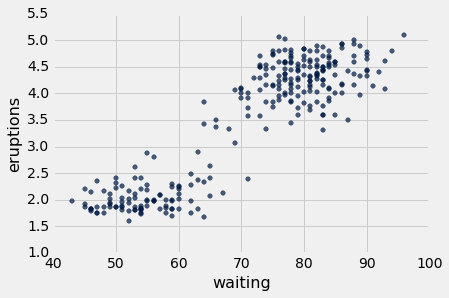

In [14]:
faithful = Table.read_table('faithful.csv')
faithful.scatter(1, 0)

It appears that there are two types of eruptions, short and long. The eruptions above 3 seconds appear correlated with waiting time.

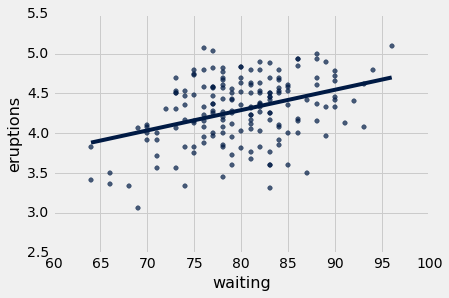

In [15]:
long = faithful.where(faithful.column('eruptions') > 3)
long.scatter(1, 0, fit_line=True)

The `rmse_geyser` function takes a slope and an intercept and returns the root mean squared error of a linear predictor of eruption size from the waiting time.

In [16]:
rmse_long = root_mean_squared_error(long, 1, 0)
rmse_long(0, 4)

0.50268461001194098

If we experiment with different values, we can find a low-error slope and intercept through trial and error.

In [17]:
rmse_long(0.01, 3.5)

0.39143872353883735

In [18]:
rmse_long(0.02, 2.7)

0.38168519564089542

The `minimize` function can be used to find the arguments of a function for which the function returns its minimum value. Python uses a similar trial-and-error approach, following the changes that lead to incrementally lower output values. 

In [19]:
a, b = minimize(rmse_long)

The root mean squared error of the minimal slope and intercept is smaller than any of the values we considered before.

In [20]:
rmse_long(a, b)

0.38014612988136354

In fact, these values `a` and `b` are the same as the values returned by the `slope` and `intercept` functions we developed based on the correlation coefficient. We see small deviations due to the inexact nature of `minimize`, but the values are essentially the same.

In [21]:
print("slope:   ", slope(long, 1, 0))
print("a:       ", a)
print("intecept:", intercept(long, 1, 0))
print("b:       ", b)

slope:    0.0255508940715
a:        0.0255496
intecept: 2.24752334164
b:        2.2476282


Therefore, we have found not only that the regression line minimizes mean squared error, but also that minimizing mean squared error gives us the regression line. The regression line is the only line that minimizes mean squared error.

## Residuals

The amount of error in each of these regression estimates is the difference between the son's height and its estimate. These errors are called *residuals*. Some residuals are positive. These correspond to points that are above the regression line – points for which the regression line under-estimates $y$. Negative residuals correspond to the line over-estimating values of $y$.

In [22]:
waiting = long.column('waiting')
eruptions = long.column('eruptions')
fitted = a * waiting + b
res = long.with_columns([
        'eruptions (fitted)', fitted,
        'residuals', eruptions - fitted
        ])
res

eruptions,waiting,eruptions (fitted),residuals
3.6,79,4.26605,-0.666047
3.333,74,4.1383,-0.805299
4.533,85,4.41934,0.113656
4.7,88,4.49599,0.204007
3.6,85,4.41934,-0.819344
4.35,85,4.41934,-0.0693442
3.917,84,4.39379,-0.476795
4.2,78,4.2405,-0.040497
4.7,83,4.36824,0.331755
4.8,84,4.39379,0.406205


As with deviations from average, the positive and negative residuals exactly cancel each other out. So the average (and sum) of the residuals is 0. Because we found `a` and `b` by numerically minimizing the root mean squared error rather than computing them exactly, the sum of residuals is slightly different from zero in this case.

In [23]:
sum(res.column('residuals'))

-0.00023579999994893797

A residual plot is a scatter plot of the residuals versus the fitted values. The residual plot of a good regression looks like the one below: a formless cloud with no pattern, centered around the horizontal axis. It shows that there is no discernible non-linear pattern in the original scatter plot.

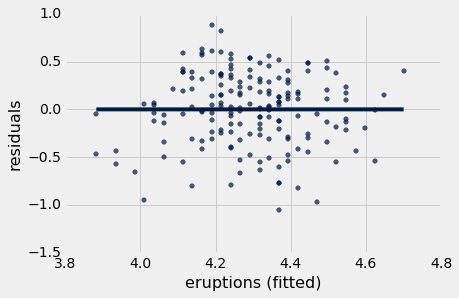

In [24]:
res.scatter(2, 3, fit_line=True)

By contrast, suppose we had attempted to fit a regression line to the entire set of eruptions of Old Faithful in the original dataset.

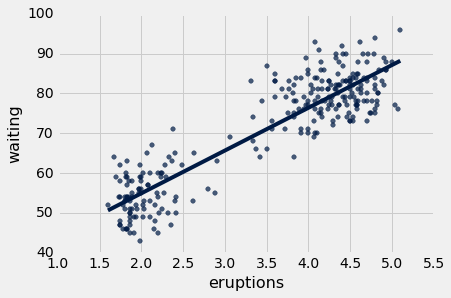

In [25]:
faithful.scatter(0, 1, fit_line=True)

This line does not pass through the average value of vertical strips. We may be able to see this fact from the scatter alone, but it is dramatically clear by visualizing the residual scatter.

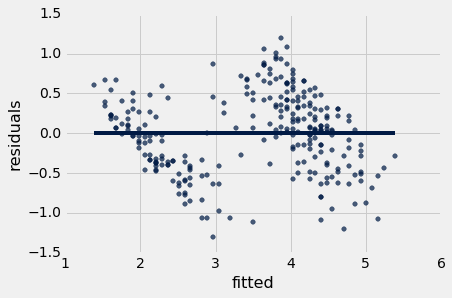

In [26]:
def residual_plot(table, x, y):
    fitted = fit(table, x, y)
    residuals = table.column(y) - fitted
    res_table = Table().with_columns([
            'fitted', fitted, 
            'residuals', residuals])
    res_table.scatter(0, 1, fit_line=True)
    
residual_plot(faithful, 1, 0)

The diagonal stripes show a non-linear pattern in the data. In this case, we would not expect the regression line to provide low-error estimates.

## Example: SAT Scores

Residual plots can be useful for spotting non-linearity in the data, or other features that weaken the regression analysis. For example, consider the SAT data of the previous section, and suppose you try to estimate the ``Combined`` score based on ``Participation Rate``.

In [27]:
sat2014 = Table.read_table('sat2014.csv')
sat2014

State,Participation Rate,Critical Reading,Math,Writing,Combined
North Dakota,2.3,612,620,584,1816
Illinois,4.6,599,616,587,1802
Iowa,3.1,605,611,578,1794
South Dakota,2.9,604,609,579,1792
Minnesota,5.9,598,610,578,1786
Michigan,3.8,593,610,581,1784
Wisconsin,3.9,596,608,578,1782
Missouri,4.2,595,597,579,1771
Wyoming,3.3,590,599,573,1762
Kansas,5.3,591,596,566,1753


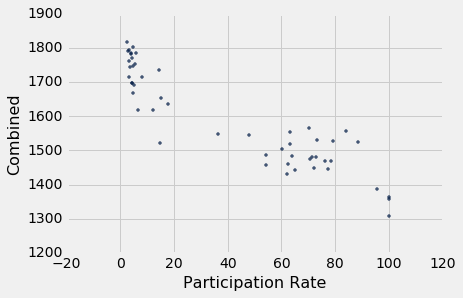

In [28]:
sat2014.scatter('Participation Rate', 'Combined', s=8)

The relation between the variables is clearly non-linear, but you might be tempted to fit a straight line anyway, especially if you never looked at a scatter diagram of the data.

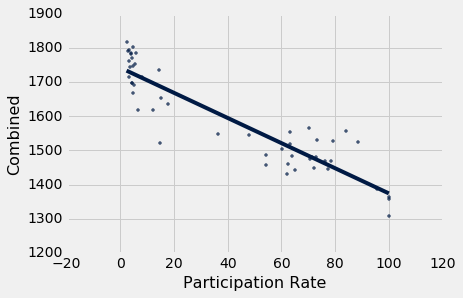

In [29]:
sat2014.scatter('Participation Rate', 'Combined', s=8, fit_line=True)

The points in the scatter plot start out above the regression line, then are consistently below the line, then above, then below. This pattern of non-linearity is more clearly visible in the residual plot.

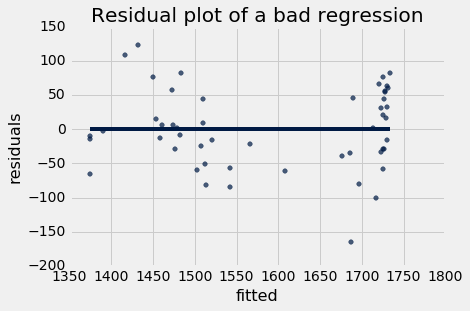

In [30]:
residual_plot(sat2014, 'Participation Rate', 'Combined')
_ = plt.title('Residual plot of a bad regression')

This residual plot is not a formless cloud; it shows a non-linear pattern, and is a signal that linear regression should not have been used for these data.

### The Size of Residuals

We will conclude by observing several relationships between quantities we have already identified. We'll illustrate the relationships using the `long` eruptions of Old Faithful, but they indeed hold for any collection of paired observations.

**Fact 1:** The root mean squared error of a line that has zero slope and an intercept at the average of `y` is the standard deviation of `y`. 

In [31]:
rmse_long(0, np.average(eruptions))

0.40967604587437784

In [32]:
np.std(eruptions)

0.40967604587437784

By contrast, the standard deviation of fitted values is smaller.

In [33]:
eruptions_fitted = fit(long, 'waiting', 'eruptions')
np.std(eruptions_fitted)

0.15271994814407569

**Fact 2**: The ratio of the standard deviations of fitted values to `y` values is $|r|$.

In [34]:
r = correlation(long, 'waiting', 'eruptions')
print('r:     ', r)
print('ratio: ', np.std(eruptions_fitted) / np.std(eruptions))

r:      0.372782225571
ratio:  0.372782225571


Notice the absolute value of $r$ in the formula above. For the heights of fathers and sons, the correlation is positive and so there is no difference between using $r$ and using its absolute value. However, the result is true for variables that have negative correlation as well, provided we are careful to use the absolute value of $r$ instead of $r$.

The regression line does a better job of estimating eruption lengths than a zero-slope line. Thus, the rough size of the errors made using the regression line must be smaller that that using a flat line. In other words, the SD of the residuals must be smaller than the overall SD of $y$.

In [35]:
eruptions_residuals = eruptions - eruptions_fitted
np.std(eruptions_residuals)

0.38014612980028634

**Fact 3**: The SD of the residuals is $\sqrt{1-r^2}$ times the SD of $y$.

In [36]:
np.std(eruptions) * (1 - r**2) ** 0.5

0.38014612980028639

**Fact 4:** The variance of the fitted values plus the variance of the residuals gives the variance of `y`.

In [37]:
np.std(eruptions_fitted) ** 2 + np.std(eruptions_residuals) ** 2

0.16783446256326531

In [38]:
np.std(eruptions) ** 2

0.16783446256326534